<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-generation-modules" data-toc-modified-id="Data-generation-modules-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data generation modules</a></span></li><li><span><a href="#Decider-modules" data-toc-modified-id="Decider-modules-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Decider modules</a></span></li><li><span><a href="#Evaluator-modules" data-toc-modified-id="Evaluator-modules-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Evaluator modules</a></span><ul class="toc-item"><li><span><a href="#Convenience-functions" data-toc-modified-id="Convenience-functions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Convenience functions</a></span></li><li><span><a href="#Contraction-algorithm" data-toc-modified-id="Contraction-algorithm-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Contraction algorithm</a></span></li><li><span><a href="#Evaluators" data-toc-modified-id="Evaluators-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Evaluators</a></span></li></ul></li><li><span><a href="#Performance-comparison" data-toc-modified-id="Performance-comparison-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Performance comparison</a></span><ul class="toc-item"><li><span><a href="#Without-unobservables-in-the-data" data-toc-modified-id="Without-unobservables-in-the-data-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Without unobservables in the data</a></span></li><li><span><a href="#With-unobservables-in-the-data" data-toc-modified-id="With-unobservables-in-the-data-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>With unobservables in the data</a></span></li></ul></li><li><span><a href="#Bayesian-sampling" data-toc-modified-id="Bayesian-sampling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Bayesian sampling</a></span></li></ul></div>

Refer to the `notes.tex` file for explanations about the modular framework.

In [18]:
# Imports

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.stats as scs
import scipy.integrate as si
import seaborn as sns
import numpy.random as npr
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Settings

%matplotlib inline

plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'figure.figsize': (10, 6)})

# Suppress deprecation warnings.

import warnings


def fxn():
    warnings.warn("deprecated", DeprecationWarning)


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

## Data generation modules

In [94]:
def inv_logit(x):
    '''Return value of inverse of logit function (logistic / sigmoid) at x.'''

    return 1.0 / (1.0 + np.exp(-1.0 * x))


def logit(p):
    return np.log(p) - np.log(1 - p)


def coinFlipDGWithoutUnobservables(N_total=50000):

    df = pd.DataFrame()

    # Sample feature X from standard Gaussian distribution, N(0, 1).
    df = df.assign(X=npr.normal(size=N_total))

    # Calculate P(Y=0|X=x) = 1 / (1 + exp(-X)) = inv_logit(X)
    df = df.assign(probabilities_Y=inv_logit(df.X))

    # Draw Y ~ Bernoulli(1 - inv_logit(X))
    # Note: P(Y=1|X=x) = 1 - P(Y=0|X=x) = 1 - inv_logit(X)
    results = npr.binomial(n=1, p=1 - df.probabilities_Y, size=N_total)

    df = df.assign(result_Y=results)

    return df


def thresholdDGWithUnobservables(N_total=50000):

    df = pd.DataFrame()

    # Sample the variables from standard Gaussian distributions.
    df = df.assign(X=npr.normal(size=N_total))
    df = df.assign(Z=npr.normal(size=N_total))
    df = df.assign(W=npr.normal(size=N_total))

    # Calculate P(Y=0|X, Z, W)
    probabilities_Y = inv_logit(beta_X * df.X + beta_Z * df.Z + beta_W * df.W)

    df = df.assign(probabilities_Y=probabilities_Y)

    # Result is 0 if P(Y = 0| X = x; Z = z; W = w) >= 0.5 , 1 otherwise
    df = df.assign(result_Y=np.where(df.probabilities_Y >= 0.5, 0, 1))

    return df


def coinFlipDGWithUnobservables(N_total=50000,
                                beta_X=1.0,
                                beta_Z=1.0,
                                beta_W=0.2):

    df = pd.DataFrame()

    # Sample feature X, Z and W from standard Gaussian distribution, N(0, 1).
    df = df.assign(X=npr.normal(size=N_total))
    df = df.assign(Z=npr.normal(size=N_total))
    df = df.assign(W=npr.normal(size=N_total))

    # Calculate P(Y=0|X=x) = 1 / (1 + exp(-X)) = inv_logit(X)
    probabilities_Y = inv_logit(beta_X * df.X + beta_Z * df.Z + beta_W * df.W)

    df = df.assign(probabilities_Y=probabilities_Y)

    # Draw Y from Bernoulli distribution
    results = npr.binomial(n=1, p=1 - df.probabilities_Y, size=N_total)

    df = df.assign(result_Y=results)

    return df

## Decider modules

In [93]:
def humanDeciderLakkaraju(df,
                          result_Y,
                          featureX_col,
                          featureZ_col=None,
                          nJudges_M=100,
                          beta_X=1,
                          beta_Z=1,
                          add_epsilon=True,
                          hide_unobserved=True):

    # Assert that every judge will have the same number of subjects.
    assert df.shape[0] % nJudges_M == 0, "Can't assign subjets evenly!"

    # Compute the number of subjects allocated for each judge.
    nSubjects_N = int(df.shape[0] / nJudges_M)

    # Assign judge IDs as running numbering from 0 to nJudges_M - 1
    df = df.assign(judgeID_J=np.repeat(range(0, nJudges_M), nSubjects_N))

    # Sample acceptance rates uniformly from a closed interval
    # from 0.1 to 0.9 and round to tenth decimal place.
    acceptance_rates = np.round(npr.uniform(.1, .9, nJudges_M), 10)

    # Replicate the rates so they can be attached to the corresponding judge ID.
    df = df.assign(acceptanceRate_R=np.repeat(acceptance_rates, nSubjects_N))

    if featureZ_col is None:
        probabilities_T = inv_logit(beta_X * df[featureX_col])
    else:
        probabilities_T = inv_logit(
            beta_X * df[featureX_col] + beta_Z * df[featureZ_col])

    if add_epsilon:
        probabilities_T += np.sqrt(0.1) * npr.normal(size=df.shape[0])

    df = df.assign(probabilities_T=probabilities_T)

    # Sort by judges then probabilities in decreasing order
    # Most dangerous for each judge are at the top.
    df.sort_values(by=["judgeID_J", "probabilities_T"],
                   ascending=False,
                   inplace=True)

    # Iterate over the data. Subject will be given a negative decision
    # if they are in the top (1-r)*100% of the individuals the judge will judge.
    # I.e. if their within-judge-index is under 1 - acceptance threshold times
    # the number of subjects assigned to each judge they will receive a
    # negative decision.
    df.reset_index(drop=True, inplace=True)

    df['decision_T'] = np.where((df.index.values % nSubjects_N) <
                                ((1 - df['acceptanceRate_R']) * nSubjects_N),
                                0, 1)

    if hide_unobserved:
        df.loc[df.decision_T == 0, result_Y] = np.nan

    return df


def coinFlipDecider(df,
                    featureX_col,
                    featureZ_col=None,
                    nJudges_M=100,
                    beta_X=1,
                    beta_Z=1,
                    add_epsilon=False,
                    hide_unobserved=True):

    # Assert that every judge will have the same number of subjects.
    assert df.shape[0] % nJudges_M == 0, "Can't assign subjets evenly!"

    # Compute the number of subjects allocated for each judge.
    nSubjects_N = int(df.shape[0] / nJudges_M)

    # Assign judge IDs as running numbering from 0 to nJudges_M - 1
    df = df.assign(judgeID_J=np.repeat(range(0, nJudges_M), nSubjects_N))

    # No real leniency here -> set to 0.5.
    acceptance_rates = np.ones(nJudges_M) * 0.5

    # Replicate the rates so they can be attached to the corresponding judge ID.
    df = df.assign(acceptanceRate_R=np.repeat(acceptance_rates, nSubjects_N))

    if featureZ_col is None:
        probabilities_T = inv_logit(beta_X * df[featureX_col])
    else:
        probabilities_T = inv_logit(
            beta_X * df[featureX_col] + beta_Z * df[featureZ_col])

    if add_epsilon:
        probabilities_T += np.sqrt(0.1) * npr.normal(size=df.shape[0])

    df = df.assign(probabilities_T=probabilities_T)

    # Draw T from Bernoulli distribution
    decisions = npr.binomial(n=1, p=1 - df.probabilities_T, size=df.shape[0])

    df = df.assign(decision_T=decisions)

    if hide_unobserved:
        df.loc[df.decision_T == 0, 'result_Y'] = np.nan

    return df


def quantileDecider(df,
                    featureX_col,
                    featureZ_col=None,
                    nJudges_M=100,
                    beta_X=1,
                    beta_Z=1,
                    add_epsilon=False,
                    hide_unobserved=True,
                    N_sim = int(1e7)):

    # Assert that every judge will have the same number of subjects.
    assert df.shape[0] % nJudges_M == 0, "Can't assign subjets evenly!"

    # Compute the number of subjects allocated for each judge.
    nSubjects_N = int(df.shape[0] / nJudges_M)

    # Assign judge IDs as running numbering from 0 to nJudges_M - 1
    df = df.assign(judgeID_J=np.repeat(range(0, nJudges_M), nSubjects_N))

    # Sample acceptance rates uniformly from a closed interval
    # from 0.1 to 0.9 and round to tenth decimal place.
    acceptance_rates = np.round(npr.uniform(.1, .9, nJudges_M), 10)

    # Replicate the rates so they can be attached to the corresponding judge ID.
    df = df.assign(acceptanceRate_R=np.repeat(acceptance_rates, nSubjects_N))

    if featureZ_col is None:
        probabilities_T = inv_logit(beta_X * df[featureX_col])
    else:
        probabilities_T = inv_logit(
            beta_X * df[featureX_col] + beta_Z * df[featureZ_col])

    if add_epsilon:
        probabilities_T += np.sqrt(0.1) * npr.normal(size=df.shape[0])

    df = df.assign(probabilities_T=probabilities_T)

    # Construct the quantile function by sampling from two Gaussians and using
    # their sum through the inverse of logit.
    probs = inv_logit(npr.normal(size=N_sim) + npr.normal(size=N_sim))

    # Now if P(Y=0|X, Z) (named 'probabilities_T') is greater than Q(r), a.k.a
    # the rth quantile of 'probs', T will be 0 and 1 otherwise.
    df = df.assign(quantile_bounds = np.quantile(probs, df.acceptanceRate_R))
    
    df = df.assign(decision_T=np.where(
        df.probabilities_T >= df.quantile_bounds, 0, 1))

    if hide_unobserved:
        df.loc[df.decision_T == 0, 'result_Y'] = np.nan

    return df

## Evaluator modules

### Convenience functions

In [21]:
def fitPredictiveModel(x_train, y_train, x_test, class_value, model_type=None):
    '''
    Fit a predictive model (default logistic regression) with given training 
    instances and return probabilities for test instances to obtain a given 
    class label.
    
    Arguments:
    ----------
    
    x_train -- x values of training instances
    y_train -- y values of training instances
    x_test -- x values of test instances
    class_value -- class label for which the probabilities are counted for.
    model_type -- type of model to be fitted.
    
    Returns:
    --------
    (1) Trained predictive model
    (2) Probabilities for given test inputs for given class.
    '''

    if model_type is None or model_type in ["logistic_regression", "lr"]:
        # Instantiate the model (using the default parameters)
        logreg = LogisticRegression(solver='lbfgs')

        # Check shape and fit the model.
        if x_train.ndim == 1:
            logreg = logreg.fit(x_train.values.reshape(-1, 1), y_train)
        else:
            logreg = logreg.fit(x_train, y_train)

        label_probs_logreg = getProbabilityForClass(x_test, logreg,
                                                    class_value)

        return logreg, label_probs_logreg

    elif model_type in ["random_forest", "rf"]:
        # Instantiate the model
        forest = RandomForestClassifier(n_estimators=100, max_depth=3)

        # Check shape and fit the model.
        if x_train.ndim == 1:
            forest = forest.fit(x_train.values.reshape(-1, 1), y_train)
        else:
            forest = forest.fit(x_train, y_train)

        label_probs_forest = getProbabilityForClass(x_test, forest,
                                                    class_value)

        return forest, label_probs_forest

    elif model_type == "fully_random":

        label_probs = np.ones_like(x_test) / 2

        model_object = lambda x: 0.5

        return model_object, label_probs
    else:
        raise ValueError("Invalid model_type!", model_type)


def getProbabilityForClass(x, model, class_value):
    '''
    Function (wrapper) for obtaining the probability of a class given x and a 
    predictive model.

    Arguments:
    -----------
    x -- individual features, an array of shape (observations, features)
    model -- a trained sklearn model. Predicts probabilities for given x. 
        Should accept input of shape (observations, features)
    class_value -- the resulting class to predict (usually 0 or 1).

    Returns:
    --------
    (1) The probabilities of given class label for each x.
    '''
    if x.ndim == 1:
        # if x is vector, transform to column matrix.
        f_values = model.predict_proba(np.array(x).reshape(-1, 1))
    else:
        f_values = model.predict_proba(x)

    # Get correct column of predicted class, remove extra dimensions and return.
    return f_values[:, model.classes_ == class_value].flatten()


def cdf(x_0, model, class_value):
    '''
    Cumulative distribution function as described above. Integral is 
    approximated using Simpson's rule for efficiency.
    
    Arguments:
    ----------
    
    x_0 -- private features of an instance for which the value of cdf is to be
        calculated.
    model -- a trained sklearn model. Predicts probabilities for given x. 
        Should accept input of shape (observations, features)
    class_value -- the resulting class to predict (usually 0 or 1).

    '''

    def prediction(x):
        return getProbabilityForClass(
            np.array([x]).reshape(-1, 1), model, class_value)

    prediction_x_0 = prediction(x_0)

    x_values = np.linspace(-15, 15, 40000)

    x_preds = prediction(x_values)

    y_values = scs.norm.pdf(x_values)

    results = np.zeros(x_0.shape[0])

    for i in range(x_0.shape[0]):

        y_copy = y_values.copy()

        y_copy[x_preds > prediction_x_0[i]] = 0
        
        results[i] = si.simps(y_copy, x=x_values)

    return results


def bailIndicator(r, y_model, x_train, x_test):
    '''
    Indicator function for whether a judge will bail or jail a suspect.
    Rationale explained above.

    Algorithm:
    ----------

    (1) Calculate recidivism probabilities from training set with a trained 
        model and assign them to predictions_train.

    (2) Calculate recidivism probabilities from test set with the trained 
        model and assign them to predictions_test.

    (3) Construct a quantile function of the probabilities in
        in predictions_train.

    (4)
    For pred in predictions_test:

        if pred belongs to a percentile (computed from step (3)) lower than r
            return True
        else
            return False

    Arguments:
    ----------

    r -- float, acceptance rate, between 0 and 1
    y_model -- a trained sklearn predictive model to predict the outcome
    x_train -- private features of the training instances
    x_test -- private features of the test instances

    Returns:
    --------
    (1) Boolean list indicating a bail decision (bail = True) for each 
        instance in x_test.
    '''

    predictions_train = getProbabilityForClass(x_train, y_model, 0)

    predictions_test = getProbabilityForClass(x_test, y_model, 0)

    return [
        scs.percentileofscore(predictions_train, pred, kind='weak') < r
        for pred in predictions_test
    ]

### Contraction algorithm

Below is an implementation of Lakkaraju's team's algorithm presented in [their paper](https://helka.finna.fi/PrimoRecord/pci.acm3098066). Relevant parameters to be passed to the function are presented in the description.

In [22]:
def contraction(df, judgeIDJ_col, decisionT_col, resultY_col, modelProbS_col,
                accRateR_col, r):
    '''
    This is an implementation of the algorithm presented by Lakkaraju
    et al. in their paper "The Selective Labels Problem: Evaluating 
    Algorithmic Predictions in the Presence of Unobservables" (2017).

    Arguments:
    -----------
    df -- The (Pandas) data frame containing the data, judge decisions,
        judge IDs, results and probability scores.
    judgeIDJ_col -- String, the name of the column containing the judges' IDs
        in df.
    decisionT_col -- String, the name of the column containing the judges' decisions
    resultY_col -- String, the name of the column containing the realization
    modelProbS_col -- String, the name of the column containing the probability
        scores from the black-box model B.
    accRateR_col -- String, the name of the column containing the judges' 
        acceptance rates
    r -- Float between 0 and 1, the given acceptance rate.

    Returns:
    --------
    (1) The estimated failure rate at acceptance rate r.
    '''
    # Get ID of the most lenient judge.
    most_lenient_ID_q = df[judgeIDJ_col].loc[df[accRateR_col].idxmax()]

    # Subset. "D_q is the set of all observations judged by q."
    D_q = df[df[judgeIDJ_col] == most_lenient_ID_q].copy()

    # All observations of R_q have observed outcome labels.
    # "R_q is the set of observations in D_q with observed outcome labels."
    R_q = D_q[D_q[decisionT_col] == 1].copy()

    # Sort observations in R_q in descending order of confidence scores S and
    # assign to R_sort_q.
    # "Observations deemed as high risk by B are at the top of this list"
    R_sort_q = R_q.sort_values(by=modelProbS_col, ascending=False)

    number_to_remove = int(
        round((1.0 - r) * D_q.shape[0] - (D_q.shape[0] - R_q.shape[0])))

    # "R_B is the list of observations assigned to t = 1 by B"
    R_B = R_sort_q[number_to_remove:R_sort_q.shape[0]]

    return np.sum(R_B[resultY_col] == 0) / D_q.shape[0]

### Evaluators

In [218]:
def contractionEvaluator(df, featureX_col, judgeIDJ_col, decisionT_col,
                         resultY_col, accRateR_col, r):

    train, test = train_test_split(df, test_size=0.5)

    B_model, predictions = fitPredictiveModel(
        train.loc[train[decisionT_col] == 1, featureX_col],
        train.loc[train[decisionT_col] == 1, resultY_col], test[featureX_col],
        0)

    test = test.assign(B_prob_0_model=predictions)

    # Invoke the original contraction.
    FR = contraction(test,
                     judgeIDJ_col=judgeIDJ_col,
                     decisionT_col=decisionT_col,
                     resultY_col=resultY_col,
                     modelProbS_col="B_prob_0_model",
                     accRateR_col=accRateR_col,
                     r=r)

    return FR


def trueEvaluationEvaluator(df, featureX_col, decisionT_col, resultY_col, r):

    train, test = train_test_split(df, test_size=0.5)

    B_model, predictions = fitPredictiveModel(train[featureX_col],
                                              train[resultY_col],
                                              test[featureX_col], 0)

    test = test.assign(B_prob_0_model=predictions)

    test.sort_values(by='B_prob_0_model', inplace=True, ascending=True)

    to_release = int(round(test.shape[0] * r))

    return np.sum(test[resultY_col][0:to_release] == 0) / test.shape[0]


def labeledOutcomesEvaluator(df, featureX_col, decisionT_col, resultY_col, r):

    train, test = train_test_split(df, test_size=0.5)

    B_model, predictions = fitPredictiveModel(
        train.loc[train[decisionT_col] == 1, featureX_col],
        train.loc[train[decisionT_col] == 1, resultY_col], test[featureX_col],
        0)

    test = test.assign(B_prob_0_model=predictions)

    test_observed = test.loc[test[decisionT_col] == 1, :]

    test_observed = test_observed.sort_values(by='B_prob_0_model',
                                              inplace=False,
                                              ascending=True)

    to_release = int(round(test_observed.shape[0] * r))

    return np.sum(
        test_observed[resultY_col][0:to_release] == 0) / test.shape[0]


def humanEvaluationEvaluator(df, judgeIDJ_col, decisionT_col, resultY_col,
                             accRateR_col, r):

    # Get judges with correct leniency as list
    is_correct_leniency = df[accRateR_col].round(1) == r

    correct_leniency_list = df.loc[is_correct_leniency, judgeIDJ_col]

    # Released are the people they judged and released, T = 1
    released = df[df[judgeIDJ_col].isin(correct_leniency_list)
                  & (df.decision_T == 1)]

    # Get their failure rate, aka ratio of reoffenders to number of people judged in total
    return np.sum(released[resultY_col] == 0) / correct_leniency_list.shape[0]


def causalEvaluator(df, featureX_col, decisionT_col, resultY_col, r):

    train, test = train_test_split(df, test_size=0.5)

    B_model, predictions = fitPredictiveModel(
        train.loc[train[decisionT_col] == 1, featureX_col],
        train.loc[train[decisionT_col] == 1, resultY_col], test[featureX_col],
        0)

    test = test.assign(B_prob_0_model=predictions)

    released = cdf(test[featureX_col], B_model, 0) < r

    return np.mean(test.B_prob_0_model * released)


def monteCarloEvaluator(df,
                        featureX_col,
                        decisionT_col,
                        resultY_col,
                        accRateR_col,
                        r,
                        N_sim=int(1e6)):

    train, test = train_test_split(df, test_size=0.5)

    B_model, predictions = fitPredictiveModel(
        train.loc[train[decisionT_col] == 1, featureX_col],
        train.loc[train[decisionT_col] == 1, resultY_col], test[featureX_col],
        0)

    test = test.assign(B_prob_0_model=predictions)

    quants = inv_logit(npr.normal(size=N_sim) + npr.normal(size=N_sim))

    Z = npr.normal(size=N_sim)
    e = np.sqrt(0.1) * npr.normal(size=N_sim)
    test = test.assign(predicted_Y=np.zeros_like(test[featureX_col]))

    q_r = np.quantile(quants, test[accRateR_col])

    test = test.assign(bounds=logit(q_r) - test[featureX_col])

    for i in range(test.shape[0]):
        Zp = []
        if test[decisionT_col].iloc[i] == 0:
            Zp = Z[Z + e > test.bounds.iloc[i]]
        else:
            Zp = Z[Z + e < test.bounds.iloc[i]]

        test.iloc[i, test.columns == 'predicted_Y'] = inv_logit(
            test[featureX_col].iloc[i] + np.mean(Zp))

    predictions = npr.binomial(n=1, p=1-test.predicted_Y, size=test.shape[0])

    test[resultY_col] = np.where(
        test[decisionT_col] == 0, predictions, test[resultY_col])

    test.sort_values(by='B_prob_0_model', inplace=True, ascending=True)

    to_release = int(round(test.shape[0] * r))

    return np.sum(test[resultY_col][0:to_release] == 0) / test.shape[0]

## Performance comparison

Below we try to replicate the results obtained by Lakkaraju and compare their model's performance to the one of ours.

### Without unobservables in the data

[1] 0 1 2 3 4 5 6 7 8 9 [2] 0 1 2 3 4 5 6 7 8 9 [3] 0 1 2 3 4 5 6 7 8 9 [4] 0 1 2 3 4 5 6 7 8 9 [5] 0 1 2 3 4 5 6 7 8 9 [6] 0 1 2 3 4 5 6 7 8 9 [7] 0 1 2 3 4 5 6 7 8 9 [8] 0 1 2 3 4 5 6 7 8 9 

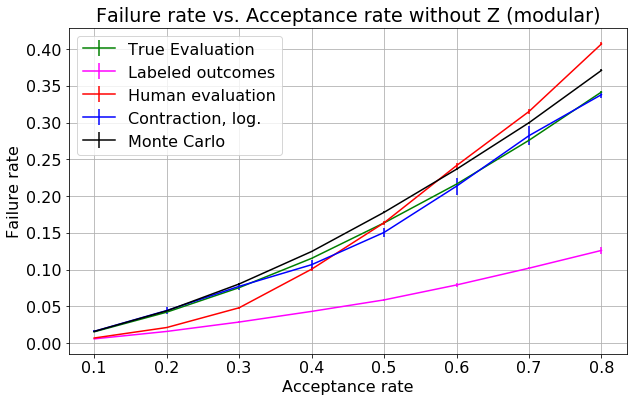

[[0.015424   0.005856   0.00700873 0.01609152 0.015964  ]
 [0.042124   0.015944   0.02125723 0.04435839 0.043916  ]
 [0.075464   0.02872    0.04810652 0.07724867 0.08046   ]
 [0.1153     0.043196   0.10059008 0.10665967 0.124604  ]
 [0.163496   0.0588     0.16363783 0.15052531 0.177884  ]
 [0.216236   0.079128   0.24141272 0.21342228 0.236504  ]
 [0.275828   0.101944   0.31497867 0.28211075 0.299696  ]
 [0.341464   0.1261     0.40679724 0.33790021 0.37086   ]]

Mean absolute errors:
0.09820600000000002
0.025143988486187003
0.004869733260249362
0.013068999999999989


In [217]:
failure_rates = np.zeros((8, 5))
failure_sems = np.zeros((8, 5))

nIter = 10

for r in np.arange(1, 9):

    print("[", r, "]", sep='', end=" ")

    f_rate_true = np.zeros(nIter)
    f_rate_label = np.zeros(nIter)
    f_rate_human = np.zeros(nIter)
    f_rate_cont = np.zeros(nIter)
    f_rate_caus = np.zeros(nIter)

    for i in range(nIter):

        print(i, end=" ")

        # Create data
        df = coinFlipDGWithoutUnobservables()

        # Decider
        df_labeled = quantileDecider(df,
                                     featureX_col="X",
                                     featureZ_col=None,
                                     nJudges_M=100,
                                     beta_X=1,
                                     beta_Z=1,
                                     hide_unobserved=True)

        df_unlabeled = quantileDecider(df,
                                       featureX_col="X",
                                       featureZ_col=None,
                                       nJudges_M=100,
                                       beta_X=1,
                                       beta_Z=1,
                                       hide_unobserved=False)

        # True evaluation

        f_rate_true[i] = trueEvaluationEvaluator(df_unlabeled, 'X',
                                                 'decision_T', 'result_Y',
                                                 r / 10)

        # Labeled outcomes only

        f_rate_label[i] = labeledOutcomesEvaluator(df_labeled, 'X',
                                                   'decision_T', 'result_Y',
                                                   r / 10)

        # Human evaluation

        f_rate_human[i] = humanEvaluationEvaluator(df_labeled, 'judgeID_J',
                                                   'decision_T', 'result_Y',
                                                   'acceptanceRate_R', r / 10)

        # Contraction

        f_rate_cont[i] = contractionEvaluator(df_labeled, 'X', 'judgeID_J',
                                              'decision_T', 'result_Y',
                                              'acceptanceRate_R', r / 10)

        # Causal model - empirical performance

        #f_rate_caus[i] = causalEvaluator(df_labeled, 'X', 'decision_T',
        #                                 'result_Y', r / 10)

        f_rate_caus[i] = monteCarloEvaluator(df_labeled, 'X', 'decision_T',
                                             'result_Y', 'acceptanceRate_R',
                                             r / 10, N_sim=int(1e5))

    failure_rates[r - 1, 0] = np.mean(f_rate_true)
    failure_rates[r - 1, 1] = np.mean(f_rate_label)
    failure_rates[r - 1, 2] = np.mean(f_rate_human)
    failure_rates[r - 1, 3] = np.mean(f_rate_cont)
    failure_rates[r - 1, 4] = np.mean(f_rate_caus)

    failure_sems[r - 1, 0] = scs.sem(f_rate_true)
    failure_sems[r - 1, 1] = scs.sem(f_rate_label)
    failure_sems[r - 1, 2] = scs.sem(f_rate_human)
    failure_sems[r - 1, 3] = scs.sem(f_rate_cont)
    failure_sems[r - 1, 4] = scs.sem(f_rate_caus)

x_ax = np.arange(0.1, 0.9, 0.1)

plt.errorbar(x_ax,
             failure_rates[:, 0],
             label='True Evaluation',
             c='green',
             yerr=failure_sems[:, 0])
plt.errorbar(x_ax,
             failure_rates[:, 1],
             label='Labeled outcomes',
             c='magenta',
             yerr=failure_sems[:, 1])
plt.errorbar(x_ax,
             failure_rates[:, 2],
             label='Human evaluation',
             c='red',
             yerr=failure_sems[:, 2])
plt.errorbar(x_ax,
             failure_rates[:, 3],
             label='Contraction',
             c='blue',
             yerr=failure_sems[:, 3])
plt.errorbar(x_ax,
             failure_rates[:, 4],
             label='Monte Carlo',
             c='black',
             yerr=failure_sems[:, 4])

plt.title('Failure rate vs. Acceptance rate without Z (modular)')
plt.xlabel('Acceptance rate')
plt.ylabel('Failure rate')
plt.legend()
plt.grid()
plt.show()

print(failure_rates)
print("\nMean absolute errors:")
for i in range(1, failure_rates.shape[1]):
    print(np.mean(np.abs(failure_rates[:, 0] - failure_rates[:, i])))

### With unobservables in the data

Lakkaraju says that they used logistic regression. We train the predictive models using only *observed observations*, i.e. observations for which labels are available. We then predict the probability of negative outcome for all observations in the test data and attach it to our data set.

[1] 0 1 2 3 4 5 6 7 8 9 [2] 0 1 2 3 4 5 6 7 8 9 [3] 0 1 2 3 4 5 6 7 8 9 [4] 0 1 2 3 4 5 6 7 8 9 [5] 0 1 2 3 4 5 6 7 8 9 [6] 0 1 2 3 4 5 6 7 8 9 [7] 0 1 2 3 4 5 6 7 8 9 [8] 0 1 2 3 4 5 6 7 8 9 

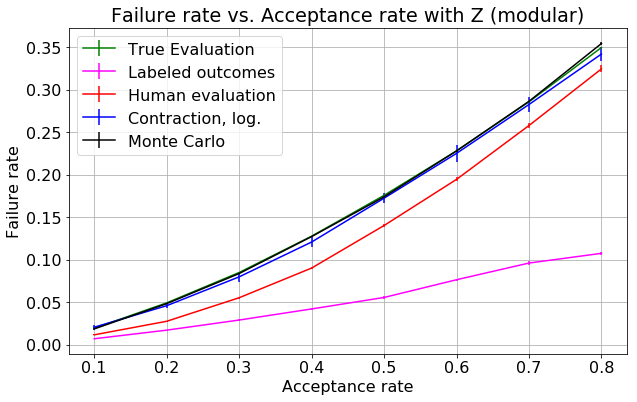

[[0.019332   0.007024   0.01164503 0.02060147 0.0186    ]
 [0.049196   0.01716    0.02757158 0.04587469 0.048304  ]
 [0.0849     0.029032   0.05524133 0.0797729  0.083684  ]
 [0.12758    0.04208    0.09012099 0.1207086  0.127128  ]
 [0.175592   0.055572   0.14012835 0.17227871 0.173824  ]
 [0.22782    0.076412   0.19436587 0.22492832 0.227844  ]
 [0.285572   0.09602    0.25768682 0.28237595 0.286128  ]
 [0.349356   0.107448   0.32420604 0.34169562 0.354052  ]]

Mean absolute errors:
0.111075
0.02729774880878927
0.004206334614321109
0.0012920000000000015


In [216]:
failure_rates = np.zeros((8, 5))
failure_sems = np.zeros((8, 5))

nIter = 10

for r in np.arange(1, 9):

    print("[", r, "]", sep='', end=" ")

    f_rate_true = np.zeros(nIter)
    f_rate_label = np.zeros(nIter)
    f_rate_human = np.zeros(nIter)
    f_rate_cont = np.zeros(nIter)
    f_rate_caus = np.zeros(nIter)

    for i in range(nIter):

        print(i, end=" ")

        # Create data
        df = coinFlipDGWithUnobservables()

        # Decider
        df_labeled = quantileDecider(df,
                                     featureX_col="X",
                                     featureZ_col="Z",
                                     nJudges_M=100,
                                     beta_X=1,
                                     beta_Z=1,
                                     hide_unobserved=True)

        df_unlabeled = quantileDecider(df,
                                       featureX_col="X",
                                       featureZ_col="Z",
                                       nJudges_M=100,
                                       beta_X=1,
                                       beta_Z=1,
                                       hide_unobserved=False)

        # True evaluation

        f_rate_true[i] = trueEvaluationEvaluator(df_unlabeled, 'X',
                                                 'decision_T', 'result_Y',
                                                 r / 10)

        # Labeled outcomes only

        f_rate_label[i] = labeledOutcomesEvaluator(df_labeled, 'X',
                                                   'decision_T', 'result_Y',
                                                   r / 10)

        # Human evaluation

        f_rate_human[i] = humanEvaluationEvaluator(df_labeled, 'judgeID_J',
                                                   'decision_T', 'result_Y',
                                                   'acceptanceRate_R', r / 10)

        # Contraction

        f_rate_cont[i] = contractionEvaluator(df_labeled, 'X', 'judgeID_J',
                                              'decision_T', 'result_Y',
                                              'acceptanceRate_R', r / 10)

        # Causal model - empirical performance

        #f_rate_caus[i] = causalEvaluator(df_labeled, 'X', 'decision_T',
        #                                 'result_Y', r / 10)

        f_rate_caus[i] = monteCarloEvaluator(df_labeled, 'X', 'decision_T',
                                             'result_Y', 'acceptanceRate_R',
                                             r / 10, N_sim=int(1e5))

    failure_rates[r - 1, 0] = np.mean(f_rate_true)
    failure_rates[r - 1, 1] = np.mean(f_rate_label)
    failure_rates[r - 1, 2] = np.mean(f_rate_human)
    failure_rates[r - 1, 3] = np.mean(f_rate_cont)
    failure_rates[r - 1, 4] = np.mean(f_rate_caus)

    failure_sems[r - 1, 0] = scs.sem(f_rate_true)
    failure_sems[r - 1, 1] = scs.sem(f_rate_label)
    failure_sems[r - 1, 2] = scs.sem(f_rate_human)
    failure_sems[r - 1, 3] = scs.sem(f_rate_cont)
    failure_sems[r - 1, 4] = scs.sem(f_rate_caus)

x_ax = np.arange(0.1, 0.9, 0.1)

plt.errorbar(x_ax,
             failure_rates[:, 0],
             label='True Evaluation',
             c='green',
             yerr=failure_sems[:, 0])
plt.errorbar(x_ax,
             failure_rates[:, 1],
             label='Labeled outcomes',
             c='magenta',
             yerr=failure_sems[:, 1])
plt.errorbar(x_ax,
             failure_rates[:, 2],
             label='Human evaluation',
             c='red',
             yerr=failure_sems[:, 2])
plt.errorbar(x_ax,
             failure_rates[:, 3],
             label='Contraction',
             c='blue',
             yerr=failure_sems[:, 3])
plt.errorbar(x_ax,
             failure_rates[:, 4],
             label='Monte Carlo',
             c='black',
             yerr=failure_sems[:, 4])

plt.title('Failure rate vs. Acceptance rate with Z (modular)')
plt.xlabel('Acceptance rate')
plt.ylabel('Failure rate')
plt.legend()
plt.grid()
plt.show()

print(failure_rates)
print("\nMean absolute errors:")
for i in range(1, failure_rates.shape[1]):
    print(np.mean(np.abs(failure_rates[:, 0] - failure_rates[:, i])))

## Bayesian sampling

In [27]:
# import pystan

# code = """
# functions{
#   // below taken from https://discourse.mc-stan.org/t/quantile-function-in-stan/3642/13
#   // as Stan doesn't have a quantile function nor supports real-to-int conversion.
#   int ub(real x) {
#     int ub = 1;
#     while (ub < x) ub *= 2;
#     return ub;
#   }

#   int closest(real x, int a, int b) {
#     return fabs(x - a) < fabs(x - b) ? a : b;
#   }

#   // L <= x <= U
#   int to_int_bsearch(real x, int L, int U);

#   int to_int_bsearch(real x, int L, int U) {
#     int mid = (L + U) / 2;
#     if (L == U) return L;
#     if (L + 1 == U) return closest(x, L, U);
#     return x <= mid? to_int_bsearch(x, L, mid) : to_int_bsearch(x, mid, U);
#   }

#   int to_int(real x);

#   int to_int(real x) {
#     if (fabs(x) >= 2^31) reject("to_int arugment must be < 2^31, found x = ", x);
#     if (x < 0) return -to_int(-x);
#     return to_int_bsearch(x, 0, ub(x));
#   }
# }

# data {
#   int<lower=0> N;
#   int<lower=0> N_quantiles;
#   real<lower=0, upper=1> r[N];
#   int<lower=0, upper=1> decision[N];
#   real X[N];
#   real<lower=0, upper=1> quantiles[N_quantiles];
# }

# parameters {
#   real Z[N];
#   real<lower=0, upper=1> p;
# }

# model {
#   Z ~ normal(0, 1);
  
#   for(i in 1:N){
#     if (inv_logit(X[i] + Z[i]) <= quantiles[to_int(r[i]*N_quantiles)])
#       decision ~ bernoulli(p);
#     else
#       decision ~ bernoulli(1-p);
#   }
# }
# """
# # Create data
# df = coinFlipDGWithUnobservables(N_total=500)

# # Decider
# df = quantileDecider(df, featureX_col="X", featureZ_col="Z", nJudges_M=10,
#                              beta_X=1, beta_Z=1, hide_unobserved=True)

# N_sim = int(1e8)

# quants = inv_logit(npr.normal(size=N_sim) + npr.normal(size=N_sim))

# dat = dict(N = df.shape[0],
#            N_quantiles = 100001,
#            r = df.acceptanceRate_R,
#            decision = df.decision_T,
#            X = df.X,
#            quantiles = np.quantile(quants, np.linspace(0, 1, 100001)))

# sm = pystan.StanModel(model_code=code)
# fit = sm.sampling(data=dat, iter=4000, chains=4)